<a href="https://colab.research.google.com/github/andresdevml/dl_writing_quality/blob/main/data_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exportamos librerias de interes**

In [59]:
import numpy as np

import pandas as pd

from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline

import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from scipy import interpolate

from google.colab import drive



# **Importamos la data**

In [60]:
# conectamos al drive
drive.mount('/content/drive')

# Definimos el directorio
dir_data_kaggle='./drive/MyDrive/lwpwq/data'


# extraemos la data

df_train_logs=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_logs.csv')

df_train_scores=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_scores.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# observemos las columnas presentes

df_train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

# **Feature Enginering**

**crearemos las caracteristicas una a una de manera manual, el data set sera un diccionario**


In [62]:
# primero hacemos el trabajo sobre todas las caractetisticas de una sola serie


id=df_train_logs['id'].unique()[1500]


df_data=df_train_logs[df_train_logs['id']==id]



# definimos una instancia de escaler que utilizaremos durante todo el proceso

scaler=StandardScaler()

In [63]:
# action_time


action_time=df_data['action_time'].values.reshape(-1,1)

# delay

up_time_displaced=pd.concat(
                              objs=[  pd.Series([0]) ,   df_data['up_time']  ],
                              ignore_index=True
                                                            )

delay_time=(df_data['down_time'].values-up_time_displaced.iloc[0:-1].values
                                                                 ).reshape(-1,1)




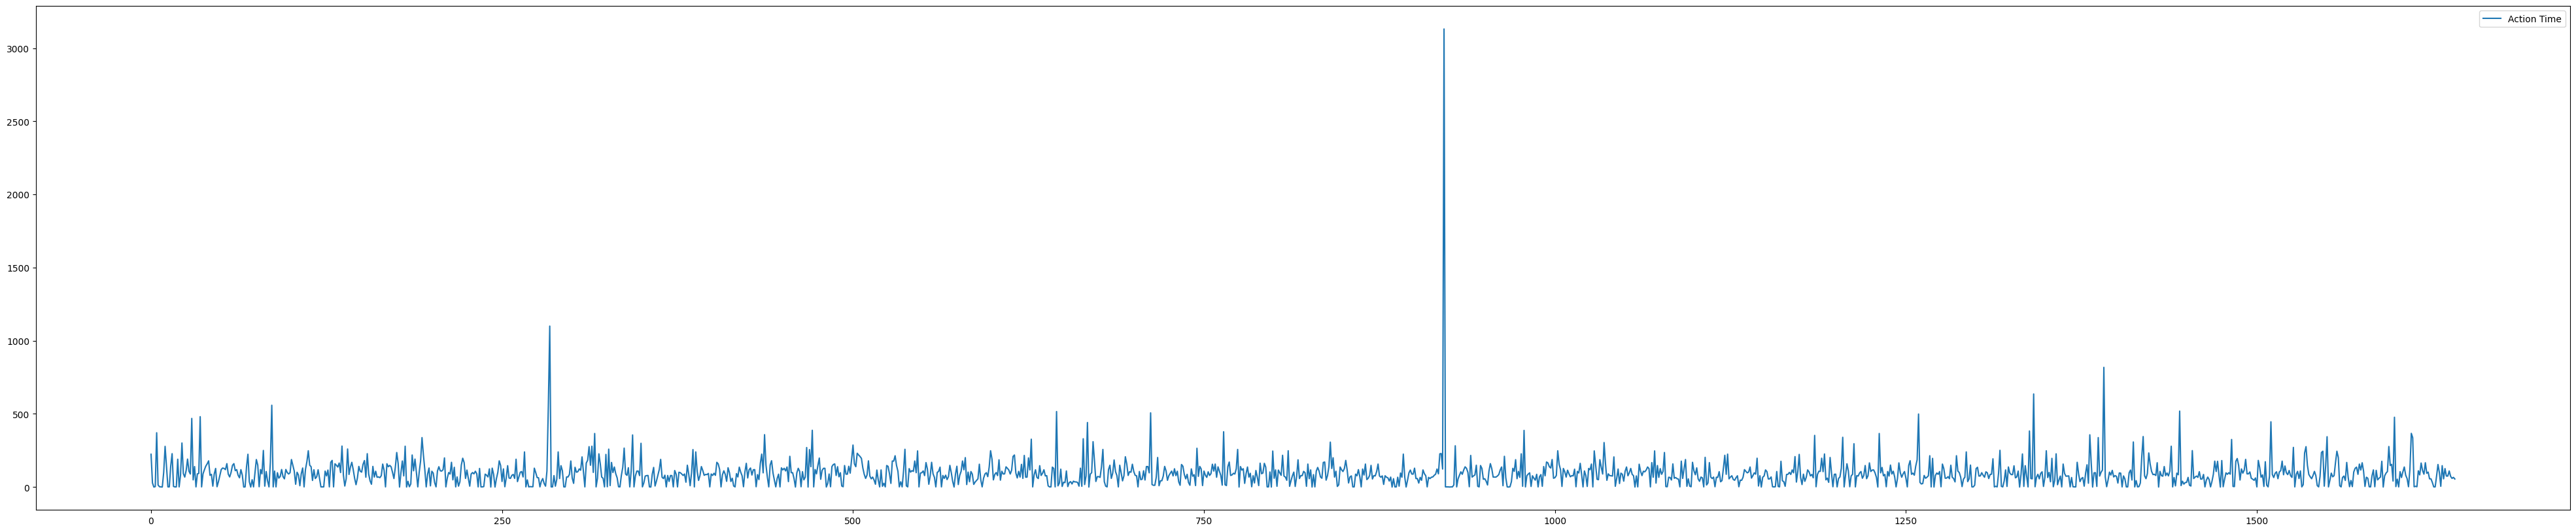

In [64]:
# grafiquemos para ver

plt.figure(figsize=(50,10))
plt.plot(action_time, label='Action Time')
plt.legend()
plt.show()


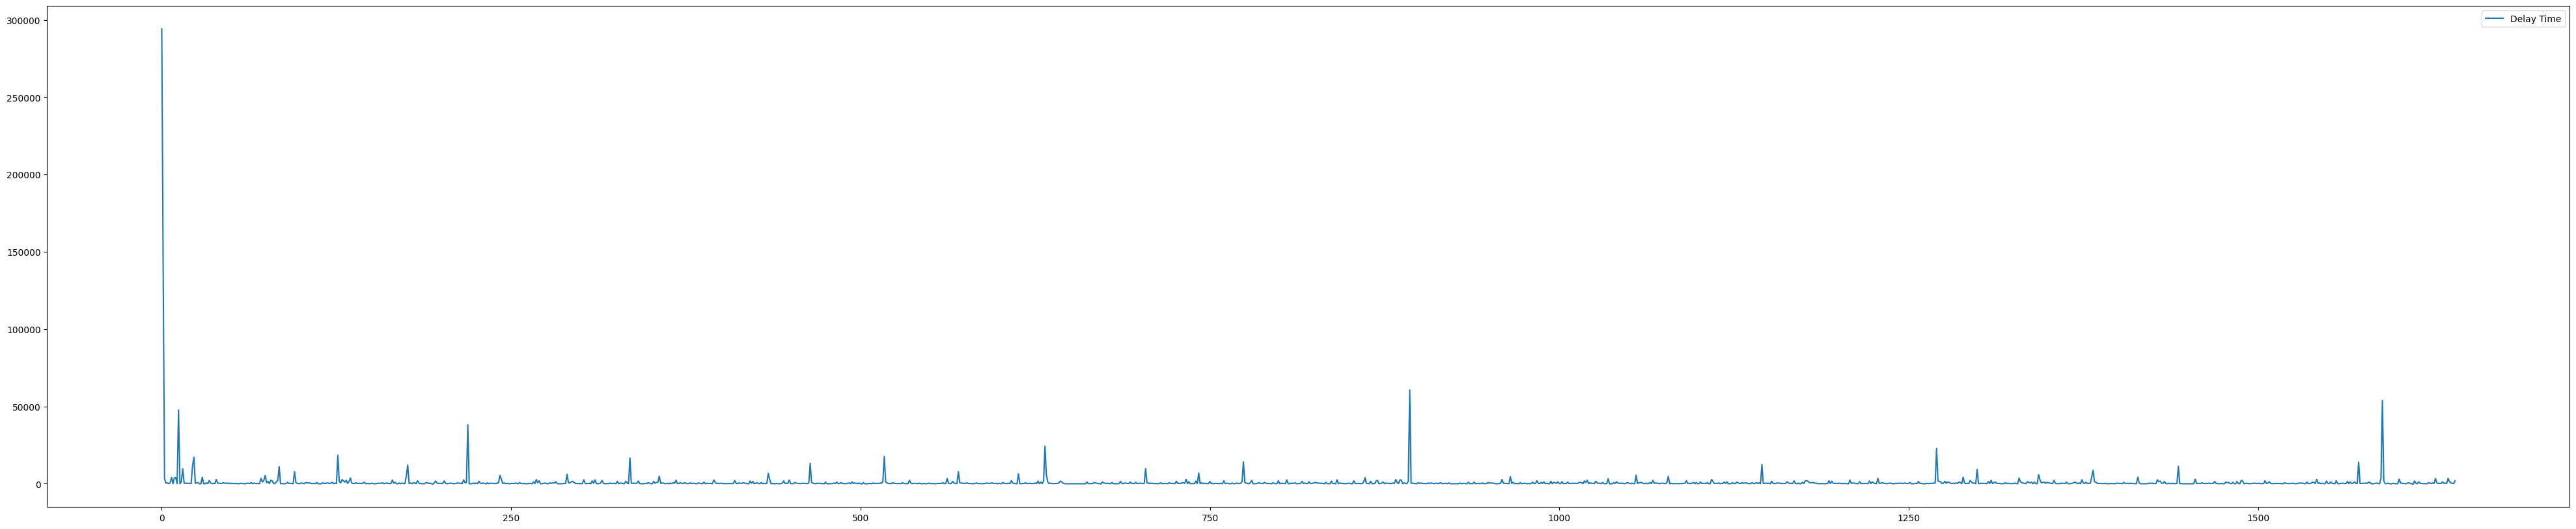

In [65]:
# grafiquemos para ver

plt.figure(figsize=(50,10))
plt.plot(delay_time, label='Delay Time')
plt.legend()
plt.show()


In [66]:
# activity

vocab_cut=df_train_logs['activity'].apply(lambda x: x[:3])

# veamos las categorias resultnates

vocab_cut.unique()

array(['Non', 'Inp', 'Rem', 'Rep', 'Mov', 'Pas'], dtype=object)

In [67]:
# veamos la frecuencioa de cada evento

vocab_cut.value_counts(normalize=True)*100

Inp    80.024716
Rem    11.541396
Non     8.373299
Rep     0.052915
Pas     0.007126
Mov     0.000547
Name: activity, dtype: float64

In [68]:
# la aplicacion de la funcion

fun_vocab_cut=vocab_cut.value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# extraemos los indices

vocab_cut=vocab_cut.value_counts(normalize=True).index.values



print(fun_vocab_cut)

Inp     0.222835
Rem     2.382065
Non     4.862187
Rep    12.406421
Pas    21.955604
Mov    34.071406
Name: activity, dtype: float64


In [69]:
# creamos el diccionario de mapeo

map_dic_activity={}
for element in zip(vocab_cut,fun_vocab_cut):
  map_dic_activity[element[0]]=element[1]

# veamos el resultado

print(map_dic_activity)

{'Inp': 0.2228346492895395, 'Rem': 2.3820645857603324, 'Non': 4.8621867810316814, 'Rep': 12.406421105384979, 'Pas': 21.955603667553245, 'Mov': 34.07140643134787}


In [70]:

# extraemos la data de la instancia de ejemplo

activity_cut=df_data['activity'].apply(lambda x: x[:3])

# aplicamos la categorizacion

cat_activity=np.array(
    activity_cut.apply(lambda x: map_dic_activity[x])).reshape(-1,1)




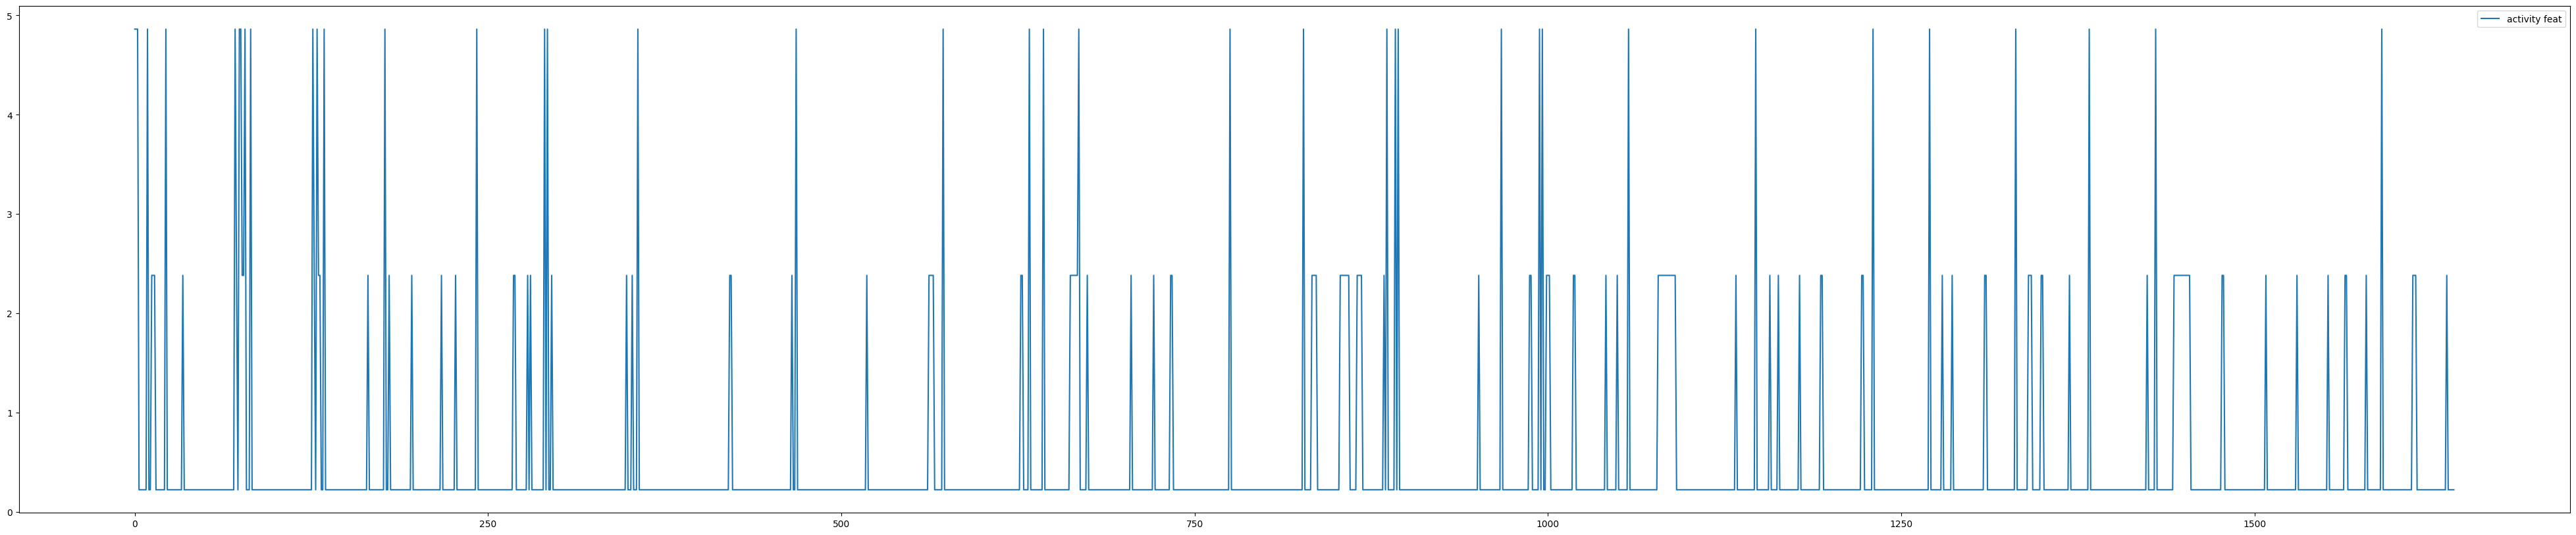

In [71]:
# veamos como queda

plt.figure(figsize=(50,10))
plt.plot(cat_activity, label='activity feat')
plt.legend()
plt.show()


In [72]:
# activity_mod


# definimos la funcion auxiliar 1
def mod_act(str_arr):
  if str_arr=='NoChange':

    return 0

  else:

    if ' => ' in str_arr:

      str_split=str_arr.split(' => ', maxsplit=1)

      return len(str_split[0])+len(str_split[1])

    else:

      return len(str_arr)

# funcion auxiliar 2
def cut_act(len_act):
  if len_act>=2:
    return 2
  else:
    return len_act


In [73]:

# veamos la distribucion

df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True)*100



1    91.527461
0     8.373299
2     0.099240
Name: text_change, dtype: float64

In [74]:
# veamos queda al aplicar la funcion

df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()


1    0.088531
0    2.568653
2    9.484039
Name: text_change, dtype: float64

In [75]:
# creamos las variables del dic


index=df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).index.values

fun_map=df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# creamos el dic

map_dic_mod_activity={}

for element in zip(index,fun_map):
  map_dic_mod_activity[element[0]]=element[1]

# veamos el resultado

print(map_dic_mod_activity)

{1: 0.08853114028924959, 0: 2.5686533355605987, 2: 9.484039221087423}


In [76]:
# aplicamos el mapeo en la instancia de ejemplo


activity_mod=df_data['text_change'].apply(mod_act).apply(cut_act)

cat_activity_mod=np.array(activity_mod.apply(lambda x: map_dic_mod_activity[x])).reshape(-1,1)



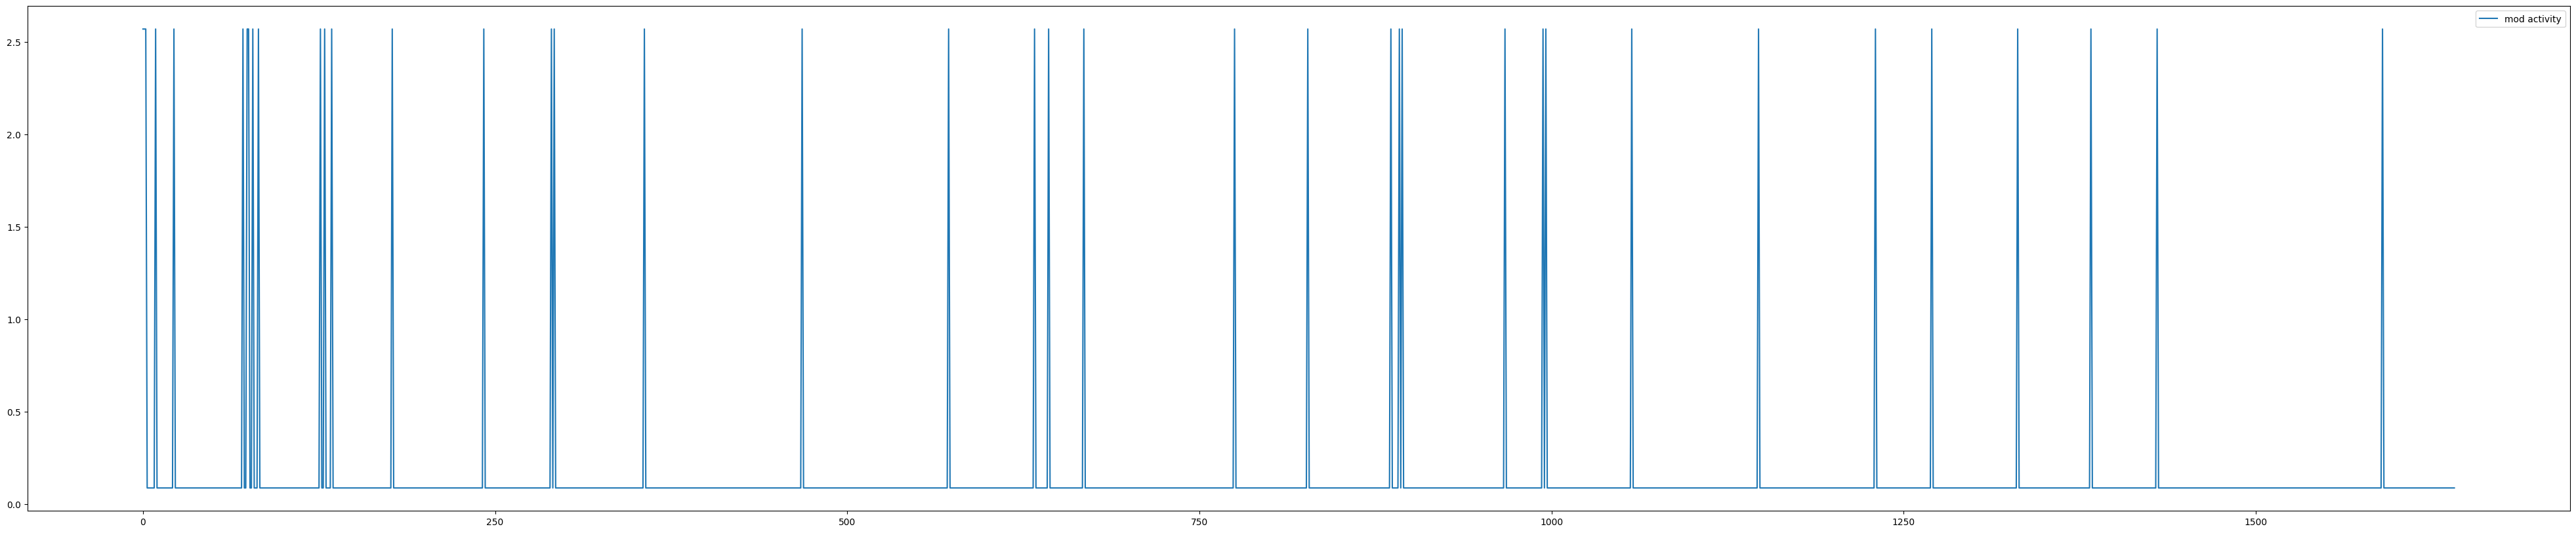

In [77]:
# veamos como queda

plt.figure(figsize=(50,10))
plt.plot(cat_activity_mod, label='mod activity')
plt.legend()
plt.show()


In [78]:
# vocabulario de up_event and down_event
# veamos como se distribuyen los eventos

df_event=pd.concat(objs=[df_train_logs['down_event'],df_train_logs['up_event']],axis=0,ignore_index=True)

vocab=list(df_event.value_counts(normalize=True)[:15].index.values)

print(vocab)

print('\n')

print(df_event.value_counts(normalize=True)[:15]*100)

['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete']


q             63.824876
Space         14.360488
Backspace     11.469197
Shift          3.976101
ArrowRight     1.443486
Leftclick      1.084072
ArrowLeft      0.752055
.              0.708859
,              0.556823
ArrowDown      0.367290
ArrowUp        0.335348
Enter          0.269918
CapsLock       0.149514
'              0.132883
Delete         0.130444
dtype: float64


In [79]:
# construimos la capa

layer_event= tf.keras.layers.StringLookup(vocabulary=vocab,
                                      num_oov_indices=1,
                                     output_mode='int')

In [80]:
# vemos como se distribuye el mapeo en la capa

pd.Series(layer_event(df_event)).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

1      0.449027
2      2.389717
3      4.555222
4      7.780091
5     12.018199
6     16.542645
7     21.432761
8     26.382029
9     31.572706
0     37.001943
10    42.608717
11    48.306474
12    54.221283
13    60.726818
14    67.350275
15    73.992256
dtype: float64

In [81]:
index=pd.Series(layer_event(df_event)).value_counts(normalize=True).index.values

fun_map=pd.Series(layer_event(df_event)).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# creamos el dic

map_dic_event={}

for element in zip(index,fun_map):
  map_dic_event[element[0]]=element[1]

# veamos el resultado

print(map_dic_event)

{1: 0.4490271610497817, 2: 2.389716778823501, 3: 4.555222046124647, 4: 7.780090524582123, 5: 12.018199366116235, 6: 16.542645083212303, 7: 21.432760712189907, 8: 26.38202894634221, 9: 31.572706427809557, 0: 37.001942853692924, 10: 42.60871732923485, 11: 48.3064743796118, 12: 54.22128303537137, 13: 60.72681801571963, 14: 67.35027528394009, 15: 73.99225578337182}


In [82]:
# mapeamos

down_event=pd.Series(layer_event(df_data['down_event'])).apply(lambda x: map_dic_event[x]).values.reshape(-1,1)

up_event=pd.Series(layer_event(df_data['up_event'])).apply(lambda x: map_dic_event[x]).values.reshape(-1,1)

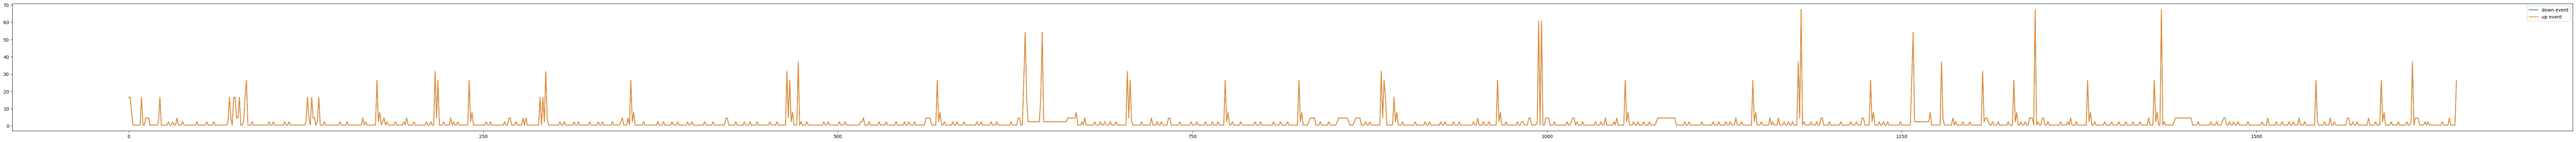

In [83]:
# visualizamos


plt.figure(figsize=(100,5))
plt.plot(down_event, label='down event')
plt.plot(up_event, label='up event')
plt.legend()
plt.show()


In [84]:
# cursor position

cursor_position=df_data['cursor_position'].values

# definimo el svr

regr_cp = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=100, epsilon=10e-21))

regr_cp.fit(
    np.arange(len(cursor_position)).reshape(-1,1),
    cursor_position)

cursor_position_lin=regr_cp.predict(
                                  np.arange(
                                                  len(cursor_position)
                                                            ).reshape(-1,1)
                                                                  )


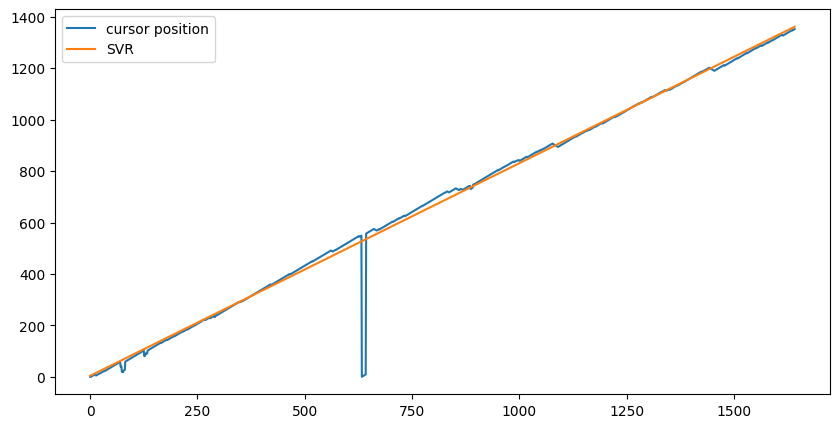

In [85]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(cursor_position)),cursor_position, label='cursor position')
plt.plot(np.arange(len(cursor_position)),cursor_position_lin, label='SVR')
plt.legend()
plt.show()

In [86]:
# cursor_position_feat


cursor_position_flat=(cursor_position_lin-cursor_position).reshape(-1,1)

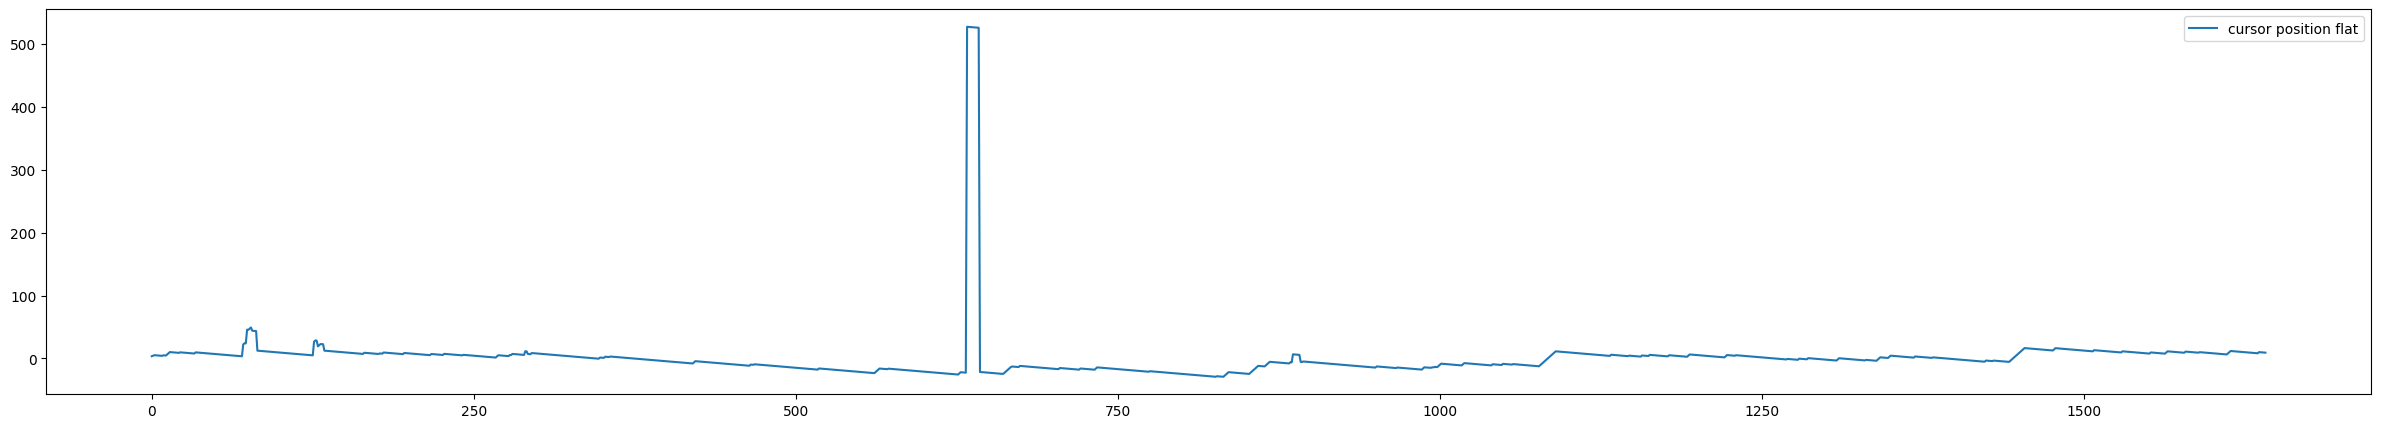

In [87]:
# establecemos la caracteristica sin la tendencia lineal

scaler = StandardScaler()


plt.figure(figsize=(30,5))
plt.plot(np.arange(len(cursor_position)),cursor_position_flat, label='cursor position flat')
plt.legend()
plt.show()

In [88]:

# aplicamos el mismo procedimiento anterior para word count

# word count

word_count=df_data['word_count'].values


# provemos el svr

regr_wc = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=100, epsilon=10e-21))

regr_wc.fit(
    np.arange(len(word_count)).reshape(-1,1),
    word_count)

word_count_lin=regr_wc.predict(
                                  np.arange(
                                                  len(word_count)
                                                            ).reshape(-1,1)
                                                                  )


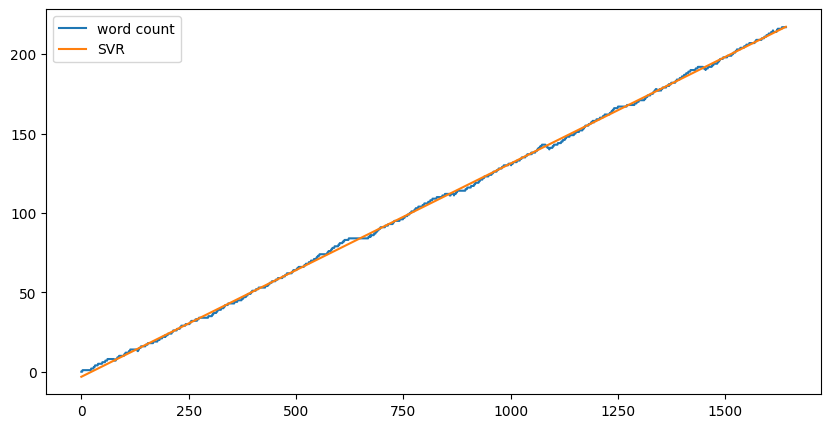

In [89]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(word_count)),word_count, label='word count')
plt.plot(np.arange(len(word_count)),word_count_lin, label='SVR')
plt.legend()
plt.show()

In [90]:

word_count_flat=(word_count_lin-word_count).reshape(-1,1)


# hacemos una interpolacion

x_dense=np.arange(len(cursor_position))


index_interp=np.floor(np.linspace(x_dense[0], x_dense[-1] ,20)).astype(int)

x=x_dense[index_interp]

y=np.squeeze(word_count_flat[index_interp])

f = interpolate.interp1d(x, y,'nearest-up')

word_count_flat_intp=f(np.arange(len(cursor_position))).reshape(-1,1)

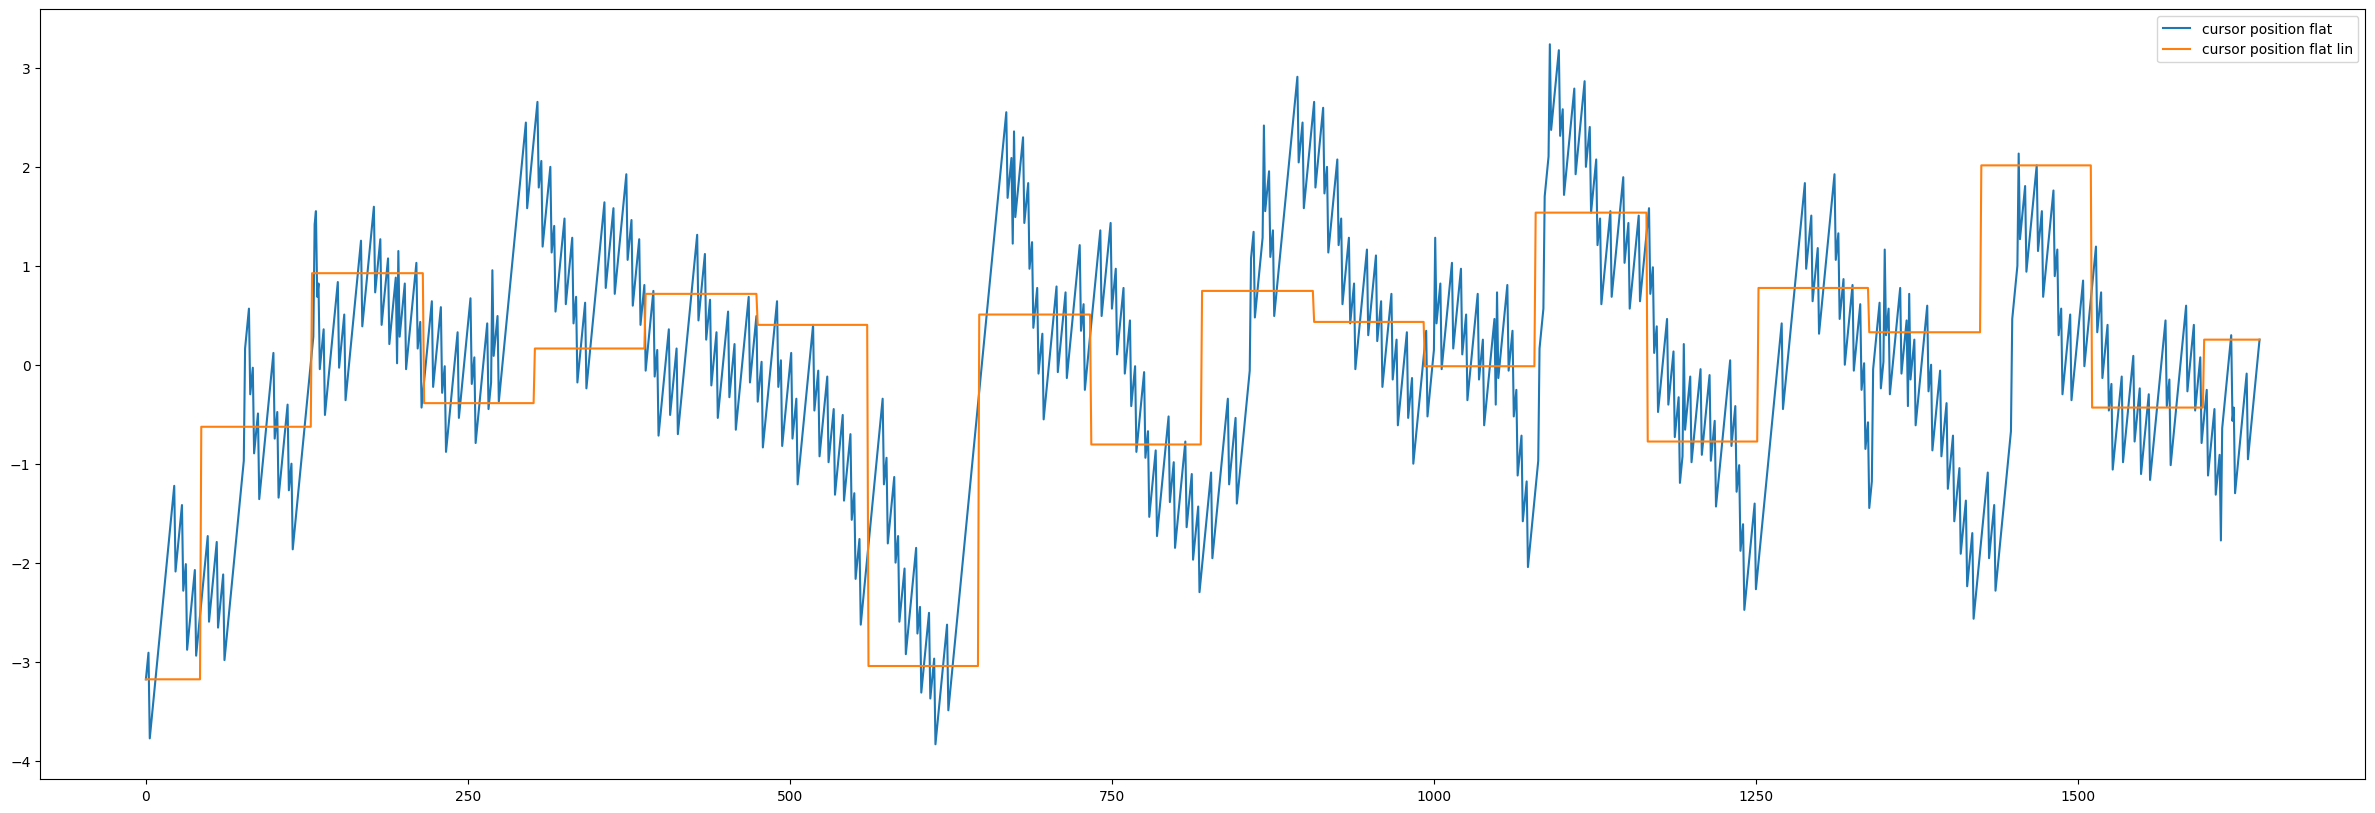

In [91]:
# establecemos la caracteristica sin la tendencia lineal


plt.figure(figsize=(30,10))
plt.plot(x_dense,word_count_flat, label='cursor position flat')
plt.plot(x_dense,word_count_flat_intp, label='cursor position flat lin')
plt.legend()

plt.show()

In [92]:

# change text

# definimos una funcion de transformacion
def text_change_format(row):

  if ' => ' in row:
    return '=>'
  else:
    return row


# aplicamos la funcion de transformacion

tc_transf=df_train_logs['text_change'].apply(text_change_format)

tc_transf.value_counts(normalize=True)[:12]*100


q           72.903668
            16.379321
NoChange     8.373299
.            0.806541
,            0.651888
\n           0.332826
'            0.156937
"            0.055425
-            0.053439
=>           0.052915
?            0.041721
;            0.034559
Name: text_change, dtype: float64

In [93]:

vocab_tc=tc_transf.value_counts(normalize=True)[:12].index.values

print(vocab_tc)

['q' ' ' 'NoChange' '.' ',' '\n' "'" '"' '-' '=>' '?' ';']


In [94]:
# Definimos la capa

layer_tc= tf.keras.layers.StringLookup(vocabulary=vocab_tc,
                                            num_oov_indices=1,
                                                  output_mode='int')



In [95]:

# aplicamos la transformacion
pd.Series(layer_tc(df_train_logs['text_change'].apply(text_change_format))).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

1      0.316031
2      2.125182
3      4.605304
4      9.425475
5     14.458528
6     20.163835
0     26.617583
7     33.074661
8     40.572549
9     48.106940
10    55.651175
11    63.433102
12    71.403358
dtype: float64

In [96]:
# creamos el diccionario

index=pd.Series(layer_tc(text_change_format(df_train_logs['text_change']))).value_counts(normalize=True).index.values

fun_map=pd.Series(layer_tc(text_change_format(df_train_logs['text_change']))).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# creamos el dic

map_dic_tc={}

for element in zip(index,fun_map):
  map_dic_tc[element[0]]=element[1]

# veamos el resultado

print(map_dic_tc)

{1: 0.3160312278984393, 2: 2.125181801189246, 3: 4.605303996460595, 4: 9.425474931582396, 5: 14.458528364954088, 6: 20.163834502209205, 0: 26.327863107546786, 7: 32.78494140359106, 8: 40.28282945205798, 9: 47.81722029648336, 11: 55.5991482066269, 12: 63.5694036976246}


In [97]:
# mapeamos la data

tc_data=pd.Series(layer_tc(df_data['text_change'].apply(text_change_format))).apply(lambda x: map_dic_tc[x]).values.reshape(-1,1)

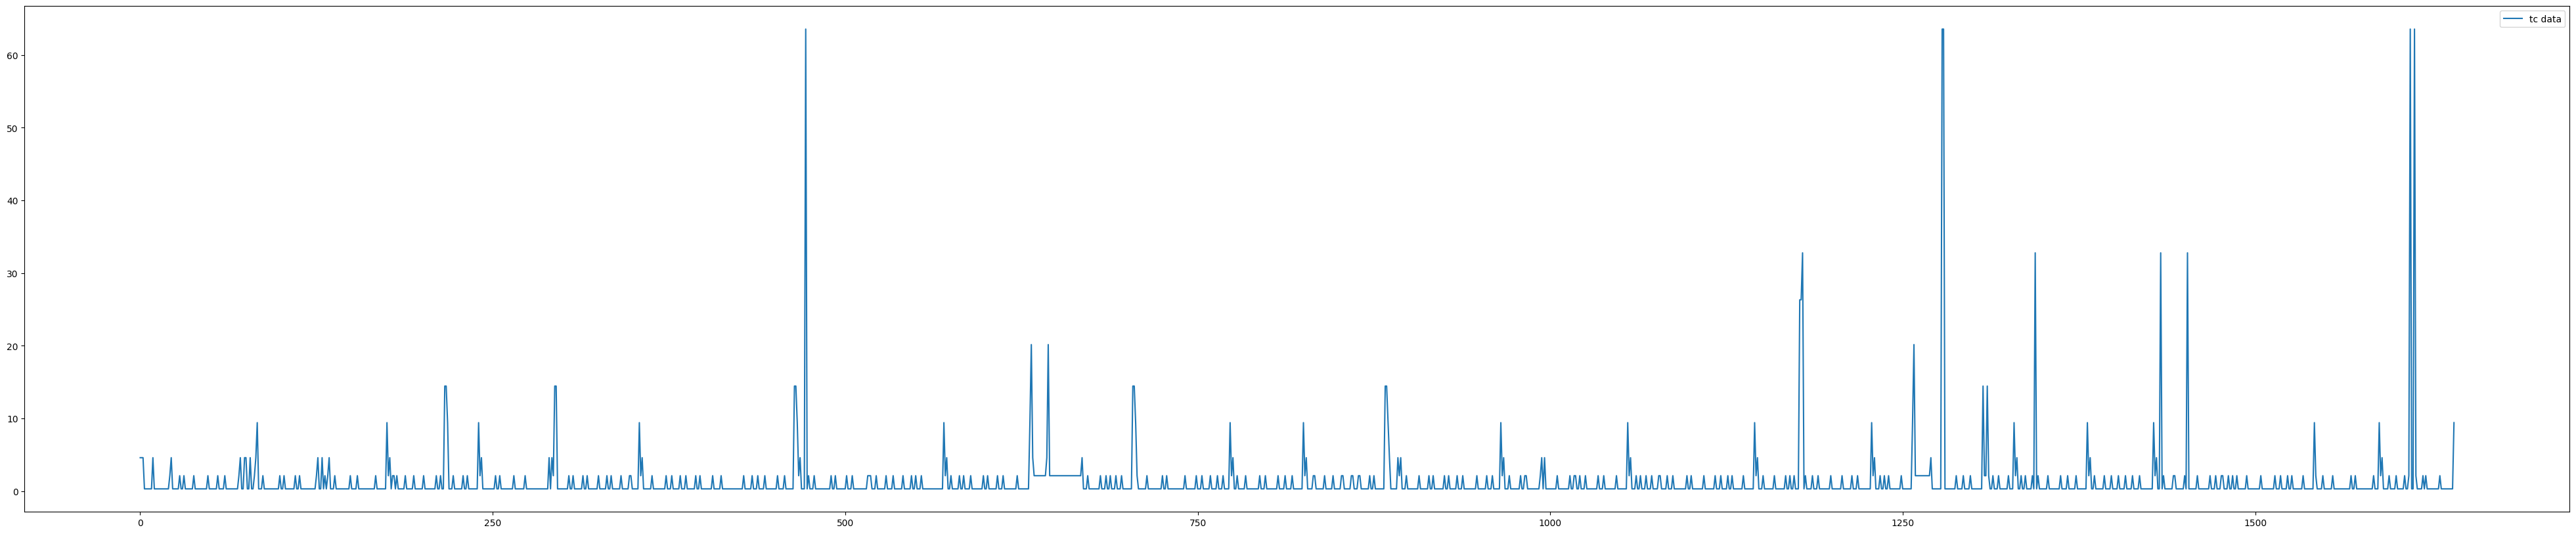

In [98]:
# veamos que tal quedo

plt.figure(figsize=(50,10))
plt.plot(tc_data, label='tc data')
plt.legend()
plt.show()

# **caracteristicas estaticas**



In [99]:
np.maximum(df_train_logs['up_time'].max(),df_train_logs['down_time'].max())


8313707

In [100]:
len_time=np.maximum(df_data['up_time'].max(),df_data['down_time'].max())/np.maximum(df_train_logs['up_time'].max(),df_train_logs['down_time'].max())
print(len_time)

0.21990671550007715


In [101]:
df_train_logs['word_count'].max()

1326

In [102]:
len_word=df_data['word_count'].max()/df_train_logs['word_count'].max()
print(len_word)

0.1636500754147813


In [103]:
df_train_logs['cursor_position'].max()

7802

In [104]:
len_cursor_position=df_data['cursor_position'].max()/df_train_logs['cursor_position'].max()
print(len_cursor_position)

0.173288900281979


# **Armamos el dicionario**

In [105]:
# veamos la data

print(id)

9f3cc888


In [106]:
# veamos las dimensiones

delay_time.shape

(1642, 1)

In [107]:
action_time.shape

(1642, 1)

In [108]:
cat_activity.shape

(1642, 1)

In [109]:
cat_activity_mod.shape

(1642, 1)

In [110]:
up_event.shape

(1642, 1)

In [111]:
cursor_position_flat.shape

(1642, 1)

In [112]:
word_count_flat_intp.shape

(1642, 1)

In [113]:
tc_data.shape

(1642, 1)

In [114]:
# concatenamos la data

dyn_data=np.hstack(
                      tup=(   delay_time,
                              action_time,
                              cat_activity,
                              cat_activity_mod,
                              cursor_position_flat,
                              word_count_flat_intp,
                              tc_data   )
                                                  )

scaler = MinMaxScaler(feature_range=(0, 5))

dyn_data=scaler.fit_transform(dyn_data)


stat_data=np.hstack(

                          tup=(len_time,len_word,len_cursor_position)

                              )

target=df_train_scores[df_train_scores['id']==id]['score'].values

In [115]:
train_data_example={

    '0a21bbd6':

     {
        'dyn_data':dyn_data,
        'stat_data':stat_data,
        'target':target
                              }
                                      }

In [116]:
train_data_example

{'0a21bbd6': {'dyn_data': array([[5.        , 0.35771319, 5.        , ..., 0.29352355, 0.        ,
          0.33905487],
         [2.34337924, 0.04471415, 5.        , ..., 0.30095874, 0.        ,
          0.33905487],
         [0.05974588, 0.        , 5.        , ..., 0.30839393, 0.        ,
          0.33905487],
         ...,
         [0.01103262, 0.0942191 , 0.        , ..., 0.34739761, 3.30464195,
          0.        ],
         [0.00750218, 0.10539764, 0.        , ..., 0.34584584, 3.30464195,
          0.        ],
         [0.03790129, 0.08783136, 0.        , ..., 0.34429406, 3.30464195,
          0.72007573]]),
  'stat_data': array([0.21990672, 0.16365008, 0.1732889 ]),
  'target': array([3.])}}